In [1]:
import sys

sys.path.append('/sdf/home/j/jvaccaro/GAMPixPy')

In [6]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from gampixpy import config
from mpl_interactions import zoom_factory
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
%matplotlib widget

infile_dir = '/sdf/data/neutrino/yuntse/coherent/SNeNDSens/g4'
physics_config = config.default_physics_params

segments_dtype = np.dtype([("event_id","u4"), ("vertex_id", "u8"), ("file_vertex_id", "u8"), ("segment_id", "u4"),
                           ("z_end", "f4"),("traj_id", "i4"), ("file_traj_id", "u4"), ("tran_diff", "f4"),
                           ("z_start", "f4"), ("x_end", "f4"),
                           ("y_end", "f4"), ("n_electrons", "u4"),
                           ("pdg_id", "i4"), ("x_start", "f4"),
                           ("y_start", "f4"), ("t_start", "f4"),
                           ("t0_start", "f8"), ("t0_end", "f8"), ("t0", "f8"),
                           ("dx", "f4"), ("long_diff", "f4"),
                           ("pixel_plane", "i4"), ("t_end", "f4"),
                           ("dEdx", "f4"), ("dE", "f4"), ("t", "f4"),
                           ("y", "f4"), ("x", "f4"), ("z", "f4"),
                           ("n_photons","f4")], align=True)

vertices_dtype = np.dtype([("event_id","u4"), ("vertex_id","u8"), ("file_vertex_id", "u8"),
                           ("x_vert","f4"), ("y_vert","f4"), ("z_vert","f4"),
                           ("t_vert","f4"), ("t_event","f4")], align=True)

def __binary_search(event_id, arr, i1, i2):
    i = int(np.floor((i2 + i1)/2))
    if (arr[i]['event_id'] == event_id):
        
        while i > 0 and arr[i - 1]['event_id'] == event_id:
            i -= 1
            
        return i

    elif i == 0 or i == (len(arr) - 1) or i1 == i2:
        raise ValueError("Event " + str(event_id) + " not found in list!")
        
    elif arr[i]['event_id'] < event_id:
        return __binary_search(event_id, arr, i + 1, i2)
        
    else:
        return __binary_search(event_id, arr, i1, i - 1)

def loadSignalEventSegments(file_id, event_id):
    sample = h5py.File(infile_dir + '/NueArCC/nueArCC_sns_g4_' + format(file_id, "04") + '.h5', 'r')
    
    segs = np.array([], dtype=segments_dtype)
    i = __binary_search(event_id, sample['segments'], 0, len(sample['segments']) - 1)
    
    while sample['segments'][i]['event_id'] == event_id:
        segs = np.append(segs, sample['segments'][i])
        i += 1
        
    return segs

def loadSignalEventVertex(file_id, event_id):
    sample = h5py.File(infile_dir + '/NueArCC/nueArCC_sns_g4_' + format(file_id, "04") + '.h5', 'r')

    vertices = np.array([], dtype=vertices_dtype)
    i = __binary_search(event_id, sample['vertices'], 0, len(sample['vertices']) - 1)

    while sample['vertices'][i]['event_id'] == event_id:
        vertices = np.append(vertices, sample['vertices'][i])
        i += 1

    return vertices

def loadCosmicsEventSegments(file_id, event_id):
    sample = h5py.File(infile_dir + '/Cosmics/CosmicFlux_g4_' + format(file_id, "04") + '.h5', 'r')
    
    segs = np.array([], dtype=segments_dtype)
    i = __binary_search(event_id, sample['segments'], 0, len(sample['segments']) - 1)
    
    while sample['segments'][i]['event_id'] == event_id:
        segs = np.append(segs, sample['segments'][i])
        i += 1
        
    return segs

def loadCosmicsEventVertex(file_id, event_id):
    sample = h5py.File(infile_dir + '/Cosmics/CosmicFlux_g4_' + format(file_id, "04") + '.h5', 'r')

    vertices = np.array([], dtype=vertices_dtype)
    i = __binary_search(event_id, sample['vertices'], 0, len(sample['vertices']) - 1)

    while sample['vertices'][i]['event_id'] == event_id:
        vertices = np.append(vertices, sample['vertices'][i])
        i += 1

    return vertices

def loadBRNEventSegments(file_id, event_id):
    sample = h5py.File(infile_dir + '/BRN/BRN_g4_' + format(file_id, "04") + '.h5', 'r')
    
    segs = np.array([], dtype=segments_dtype)
    i = __binary_search(event_id, sample['segments'], 0, len(sample['segments']) - 1)
    
    while sample['segments'][i]['event_id'] == event_id:
        segs = np.append(segs, sample['segments'][i])
        i += 1
        
    return segs

def loadBRNEventVertex(file_id, event_id):
    sample = h5py.File(infile_dir + '/BRN/BRN_g4_' + format(file_id, "04") + '.h5', 'r')

    vertices = np.array([], dtype=vertices_dtype)
    i = __binary_search(event_id, sample['vertices'], 0, len(sample['vertices']) - 1)

    while sample['vertices'][i]['event_id'] == event_id:
        vertices = np.append(vertices, sample['vertices'][i])
        i += 1

    return vertices

In [7]:
detector_bounds = [[-30, 30], [-25, 25], [-30, 30]] # cm (x, y, z)
def draw_boundaries(ax):
    """
    Draw the detector boundaries as a wireframe
    not needed, but pretty
    """
    boundKwargs = {'color': 'black',
                   'ls': '--'}
    
    ax.plot([detector_bounds[0][0], detector_bounds[0][1]],
            [detector_bounds[1][0], detector_bounds[1][0]],
            [detector_bounds[2][0], detector_bounds[2][0]],
            **boundKwargs)
    ax.plot([detector_bounds[0][0], detector_bounds[0][1]],
            [detector_bounds[1][1], detector_bounds[1][1]],
            [detector_bounds[2][0], detector_bounds[2][0]],
            **boundKwargs)
    ax.plot([detector_bounds[0][0], detector_bounds[0][1]],
            [detector_bounds[1][0], detector_bounds[1][0]],
            [detector_bounds[2][1], detector_bounds[2][1]],
            **boundKwargs)
    ax.plot([detector_bounds[0][0], detector_bounds[0][1]],
            [detector_bounds[1][1], detector_bounds[1][1]],
            [detector_bounds[2][1], detector_bounds[2][1]],
            **boundKwargs)

    ax.plot([detector_bounds[0][0], detector_bounds[0][0]],
            [detector_bounds[1][0], detector_bounds[1][1]],
            [detector_bounds[2][0], detector_bounds[2][0]],
            **boundKwargs)
    ax.plot([detector_bounds[0][1], detector_bounds[0][1]],
            [detector_bounds[1][0], detector_bounds[1][1]],
            [detector_bounds[2][0], detector_bounds[2][0]],
            **boundKwargs)
    ax.plot([detector_bounds[0][0], detector_bounds[0][0]],
            [detector_bounds[1][0], detector_bounds[1][1]],
            [detector_bounds[2][1], detector_bounds[2][1]],
            **boundKwargs)
    ax.plot([detector_bounds[0][1], detector_bounds[0][1]],
            [detector_bounds[1][0], detector_bounds[1][1]],
            [detector_bounds[2][1], detector_bounds[2][1]],
            **boundKwargs)

    ax.plot([detector_bounds[0][0], detector_bounds[0][0]],
            [detector_bounds[1][0], detector_bounds[1][0]],
            [detector_bounds[2][0], detector_bounds[2][1]],
            **boundKwargs)
    ax.plot([detector_bounds[0][0], detector_bounds[0][0]],
            [detector_bounds[1][1], detector_bounds[1][1]],
            [detector_bounds[2][0], detector_bounds[2][1]],
            **boundKwargs)
    ax.plot([detector_bounds[0][1], detector_bounds[0][1]],
            [detector_bounds[1][0], detector_bounds[1][0]],
            [detector_bounds[2][0], detector_bounds[2][1]],
            **boundKwargs)
    ax.plot([detector_bounds[0][1], detector_bounds[0][1]],
            [detector_bounds[1][1], detector_bounds[1][1]],
            [detector_bounds[2][0], detector_bounds[2][1]],
            **boundKwargs)

    return ax

In [8]:
gampix_output = h5py.File('/sdf/data/neutrino/jvaccaro/NueArCC_gampixpy/nueArCC_sns_g4_gampixpy_0000.h5', 'r')
edepsim_output = h5py.File('/sdf/data/neutrino/yuntse/coherent/SNeNDSens/g4/NueArCC/nueArCC_sns_g4_0000.h5', 'r')

file_id = 0
event_id = 1
event_pixel_hit_mask = gampix_output['pixel_hits']['event id'] == event_id
event_pixel_hits = gampix_output['pixel_hits'][event_pixel_hit_mask]
truth_data = loadSignalEventSegments(file_id, event_id)

# Recalculate `hit x` to account for vertex timing
vertex = loadSignalEventVertex(file_id, event_id)[0]
drift_time = event_pixel_hits['hit t'] - vertex['t_vert']
tpc_index_selector = 2 * event_pixel_hits['tpc index'].astype(int) - 1 # -1 for TPC index 0, 1 for TPC index 1
hit_x = (30 - drift_time * physics_config['charge_drift']['drift_speed']) * tpc_index_selector

# Calculate charge deposited after recombination by accounting for electron lifetime in LAr
charge = event_pixel_hits['hit charge'] * np.exp(drift_time / physics_config['charge_drift']['electron_lifetime'])

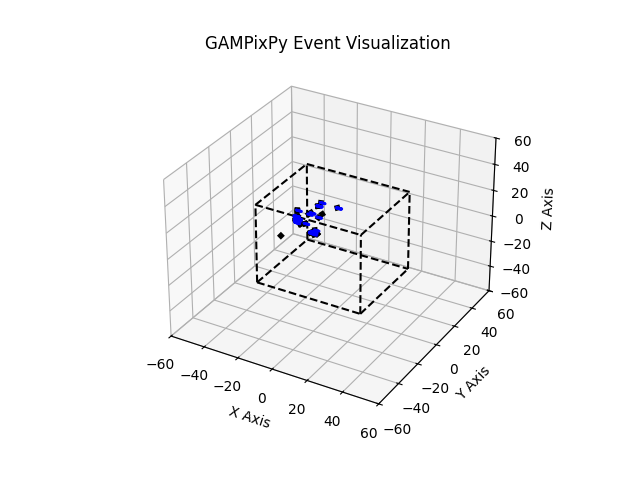

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
plt.title('GAMPixPy Event Visualization')

draw_boundaries(ax)

ax.scatter(hit_x,
           event_pixel_hits['hit y'],
           event_pixel_hits['hit z'],
           c = 'b', s = 1)

for seg in truth_data:
    ax.plot((seg['x_start'], seg['x_end']), (seg['y_start'], seg['y_end']), (seg['z_start'], seg['z_end']), color='black', linestyle='-', linewidth=4)

ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_zlim(-60, 60)

# Add labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

disconnect_zoom = zoom_factory(ax, base_scale=1.02)

plt.show()

Estimated number of clusters: 14
Estimated number of noise points: 0


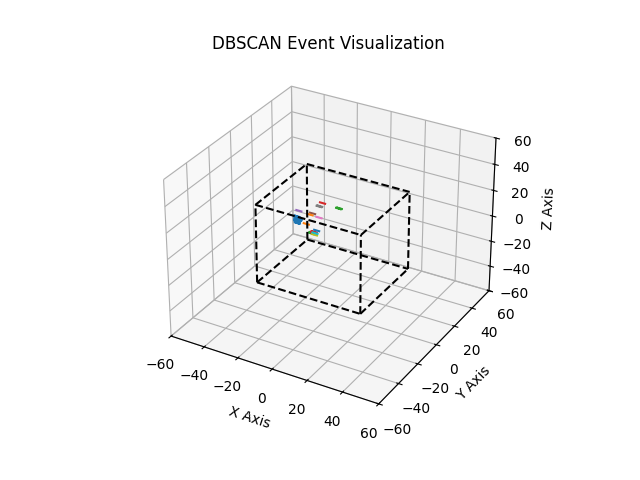

In [10]:
# Initialize figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('DBSCAN Event Visualization')

# DBSCAN parameters
EPSILON = 0.6
MIN_SAMPLES = 6
dbscan = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES)

db = dbscan.fit(np.column_stack((hit_x, event_pixel_hits['hit y'], event_pixel_hits['hit z'])))
labels = db.labels_
unique_labels = set(labels)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    plt.plot(
        hit_x[class_member_mask],
        event_pixel_hits[class_member_mask]['hit y'],
        event_pixel_hits[class_member_mask]['hit z'],
        markerfacecolor=tuple(col),
        markersize=1,
    )

# Set limits to reflect detector geometry
draw_boundaries(ax)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_zlim(-60, 60)

# Add labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Enable scroll to zoom with zoom_factory
disconnect_zoom = zoom_factory(ax, base_scale=1.02)

# Show the plot
plt.show()

Estimated number of clusters: 14
Estimated number of noise points: 0


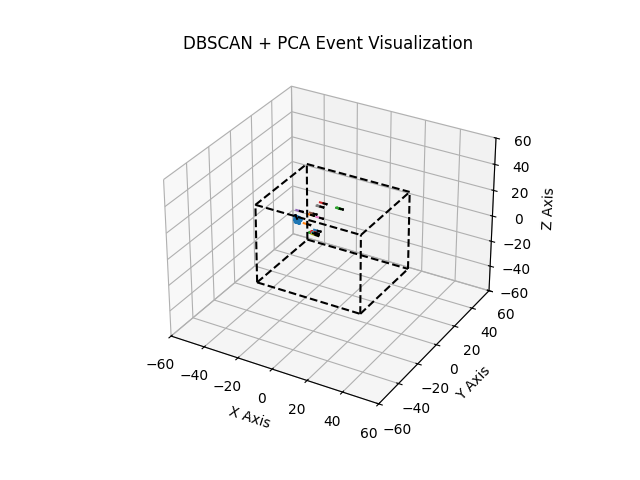

In [11]:
# Initialize figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
plt.title('DBSCAN + PCA Event Visualization')

# DBSCAN parameters
EPSILON = 0.6
MIN_SAMPLES = 6
dbscan = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES)

db = dbscan.fit(np.column_stack((hit_x, event_pixel_hits['hit y'], event_pixel_hits['hit z'])))
labels = db.labels_
unique_labels = set(labels)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    plt.plot(
        hit_x[class_member_mask],
        event_pixel_hits[class_member_mask]['hit y'],
        event_pixel_hits[class_member_mask]['hit z'],
        markerfacecolor=tuple(col),
        markersize=1,
    )
        
    # Initialize PCA for each cluster
    pca = PCA(n_components=1)
    pca.fit(np.column_stack((hit_x[class_member_mask], event_pixel_hits[class_member_mask]['hit y'], event_pixel_hits[class_member_mask]['hit z'])))
    
    for length, vector in zip(pca.explained_variance_, pca.components_):
        v = vector * 3 * np.sqrt(length)
        ax.quiver(pca.mean_[0], pca.mean_[1], pca.mean_[2], v[0], v[1], v[2], color='black')

# Set limits to reflect detector geometry
draw_boundaries(ax)
ax.set_xlim(-60, 60)
ax.set_ylim(-60, 60)
ax.set_zlim(-60, 60)

# Add labels
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Enable scroll to zoom with zoom_factory
disconnect_zoom = zoom_factory(ax, base_scale=1.02)

# Show the plot
plt.show()

In [12]:
print(physics_config['material']['w'])

2.36e-05


In [13]:
def inverseBirksModel(dQdx):
    a = physics_config['birks_model']['birks_ab'] / physics_config['material']['w']
    b = physics_config['birks_model']['birks_kb'] / (physics_config['charge_drift']['drift_field'] * physics_config['material']['density'])
    return dQdx / (a - b * dQdx)

In [14]:
# DBSCAN parameters
EPSILON = 0.6
MIN_SAMPLES = 6
dbscan = DBSCAN(eps=EPSILON, min_samples=MIN_SAMPLES)

db = dbscan.fit(np.column_stack((hit_x, event_pixel_hits['hit y'], event_pixel_hits['hit z'])))
labels = db.labels_
unique_labels = set(labels)

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(unique_labels) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

dQ = np.array([], dtype=np.float64)
dx = np.array([], dtype=np.float64)
for k in unique_labels:
    if k == -1:
        continue

    class_member_mask = labels == k

    dQ = np.append(dQ, np.sum(charge[class_member_mask]))
    
    # Initialize PCA for each cluster
    pca = PCA(n_components=1)
    transformed_data = pca.fit_transform(np.column_stack((hit_x[class_member_mask], event_pixel_hits[class_member_mask]['hit y'], event_pixel_hits[class_member_mask]['hit z'])))
    dx = np.append(dx, pca.explained_variance_[0] * (np.max(transformed_data) - np.min(transformed_data)))

dEdx = inverseBirksModel(dQ / dx)
dE = dx * dEdx
print(np.sum(dE))

Estimated number of clusters: 14
Estimated number of noise points: 0
32.22083899838879
